### Load modules

In [1]:
# initialize and load modules
#%matplotlib notebook
from pythonXdmfReader.pythonXdmfReader import*
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')

import matplotlib.gridspec as gridspec
import matplotlib.tri as tri
import pyproj
import scipy.io as sio
from palettable.scientific import sequential as cmapa
from matplotlib import colors, cm

import numpy as np
import os

import itertools
import networkx as nx

print('module loaded')

module loaded


##### Consistent fontsize across plots

In [2]:
from Lib_GeneralFunctions import *

#Plot fontsize controller
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
FontSizeControlFreak(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE)

In [3]:
ModelFolder = '/import/freenas-m-05-seissol/jhayek/Data_SupNG/Qinghai/'
# model name
modelname = 'H096'




### Load data from the xdmf file

In [4]:
# load data

lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
#lla = pyproj.Proj('EPSG:32647')
myproj = pyproj.Proj(proj='lcc', init='EPSG:3415')

xdmfFilename = ModelFolder + modelname+'-fault.xdmf'

ndt = ReadNdt(xdmfFilename)-2
xyz = ReadGeometry(xdmfFilename)
connect = ReadConnect(xdmfFilename)


In [5]:
XY_0,XY_1 = pyproj.transform(myproj,lla,xyz[:,0],xyz[:,1])

xyz[:,0] = XY_0
xyz[:,1] = XY_1

/import/freenas-m-02-seismology/jhayek/miniconda3/envs/Seissol/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  """Entry point for launching an IPython kernel.


In [6]:
#%%
asl= LoadData(xdmfFilename,'ASl',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
vr =LoadData(xdmfFilename,'Vr',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
td = LoadData(xdmfFilename,'T_d',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
# srd=LoadData(xdmfFilename,'PSR',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
#%%

### Extract only connected nodes and face ID per surface

In [7]:
#create graph
edges = []
for face in connect:
    edges.extend(list(itertools.combinations(face, 2)))
g = nx.from_edgelist(edges)

# compute connected components and print results
components = list(nx.algorithms.components.connected_components(g))

FaceIDX_Dict = dict()
F_idx = 0

component_to_faces = dict()
for component in components:
    component_to_faces[tuple(component)] = [face for face in connect if set(face) <= component] # <= operator tests for subset relation
    FaceIDX_Dict[F_idx] = [True if set(face) <= component else False for face in connect ]
    F_idx +=1

#### Separate the fault branches to easen visualization

In [8]:
NodeID =[]
VertexID = []

for key,item in component_to_faces.items():
    NodeID.append(np.array(key))
    VertexID.append(np.array(item))

NodeID[2]

array([ 13181,  13182,  13183, ..., 108489, 108490, 108491], dtype=uint64)

In [9]:
import matplotlib.tri as tri

In [10]:
TagNo = 0

ConnectionMask = np.ones(connect.shape[0]) # Mask out everything
ConnectionMask[FaceIDX_Dict[TagNo]] = 0 # Assign the triangles Idx a value of zero to show

triang2 = tri.Triangulation(xyz[:,0],xyz[:,2], connect, mask=ConnectionMask)
TagNo = 1

ConnectionMask = np.ones(connect.shape[0]) # Mask out everything
ConnectionMask[FaceIDX_Dict[TagNo]] = 0 # Assign the triangles Idx a value of zero to show

triang3 = tri.Triangulation(xyz[:,0],xyz[:,2], connect, mask=ConnectionMask)
TagNo = 2

ConnectionMask = np.ones(connect.shape[0]) # Mask out everything
ConnectionMask[FaceIDX_Dict[TagNo]] = 0 # Assign the triangles Idx a value of zero to show

triang1 = tri.Triangulation(xyz[:,0],xyz[:,2], connect, mask=ConnectionMask)

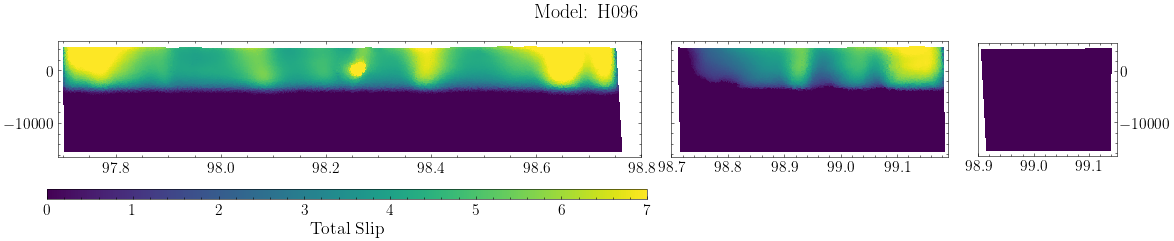

In [11]:
Intensity = asl[0]
VMax = 7

fig = plt.figure(figsize=(15, 2.5), dpi=80)

gs0 = gridspec.GridSpec(1, 4, figure=fig,width_ratios=[1,1,1,0.5])

ax1 = fig.add_subplot(gs0[0, :2])
ax2 = fig.add_subplot(gs0[0, 2])
ax3 = fig.add_subplot(gs0[0, 3])



im = ax1.tripcolor(triang1,Intensity,vmin=0.0,vmax=VMax)
ax2.tripcolor(triang2,Intensity,vmin=0.0,vmax=VMax)
ax3.tripcolor(triang3,Intensity,vmin=0.0,vmax=VMax)


ax1.set_xlim([97.69,98.8])
ax2.set_xlim([98.7,99.19])
ax3.set_xlim([98.9,99.15])

ax1.set_aspect(1/100000)
ax2.set_aspect(1/108000)
ax3.set_aspect(1/108000)


"""
ax1.set_xlim([379000,480000])
ax2.set_xlim([470000,520000])
ax3.set_xlim([490000,515000])

ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)
"""

ax2.set_yticklabels("")
ax3.yaxis.tick_right()
plt.tight_layout()

cax = fig.add_axes([0.05, 0.0, 0.5, 0.05])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Total Slip')
fig.suptitle("Model: {}".format(modelname))


OutFolder = "/import/freenas-m-03-geodynamics/jhayek/SharedWolfel/OnTibetEvent/TibetModels/"
plt.savefig(OutFolder+modelname+".png")